In [ ]:
from lyutool import *

In [ ]:
import pathlib
import matplotlib.pyplot as plt
import laspy as las
from scipy.spatial.kdtree import KDTree
import numpy as np
import scipy
from sklearn.decomposition import PCA
from tqdm import tqdm

In [ ]:
def show(points, rgb):
    fig = plt.figure(figsize=[10,10])
    ax = fig.add_axes([0,0,1,1],projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=0.1, c=rgb)
    return ax

In [ ]:
las_fp = pathlib.Path('/home/hxl170008/data/124.las')
inFile = las.file.File(las_fp, mode='r')
xyz = np.vstack([inFile.x, inFile.y, inFile.z]).transpose()
rgb = np.vstack([inFile.red, inFile.green, inFile.blue]).transpose()
rgb = rgb/65536
#
lp_xyz = LPoints(xyz)

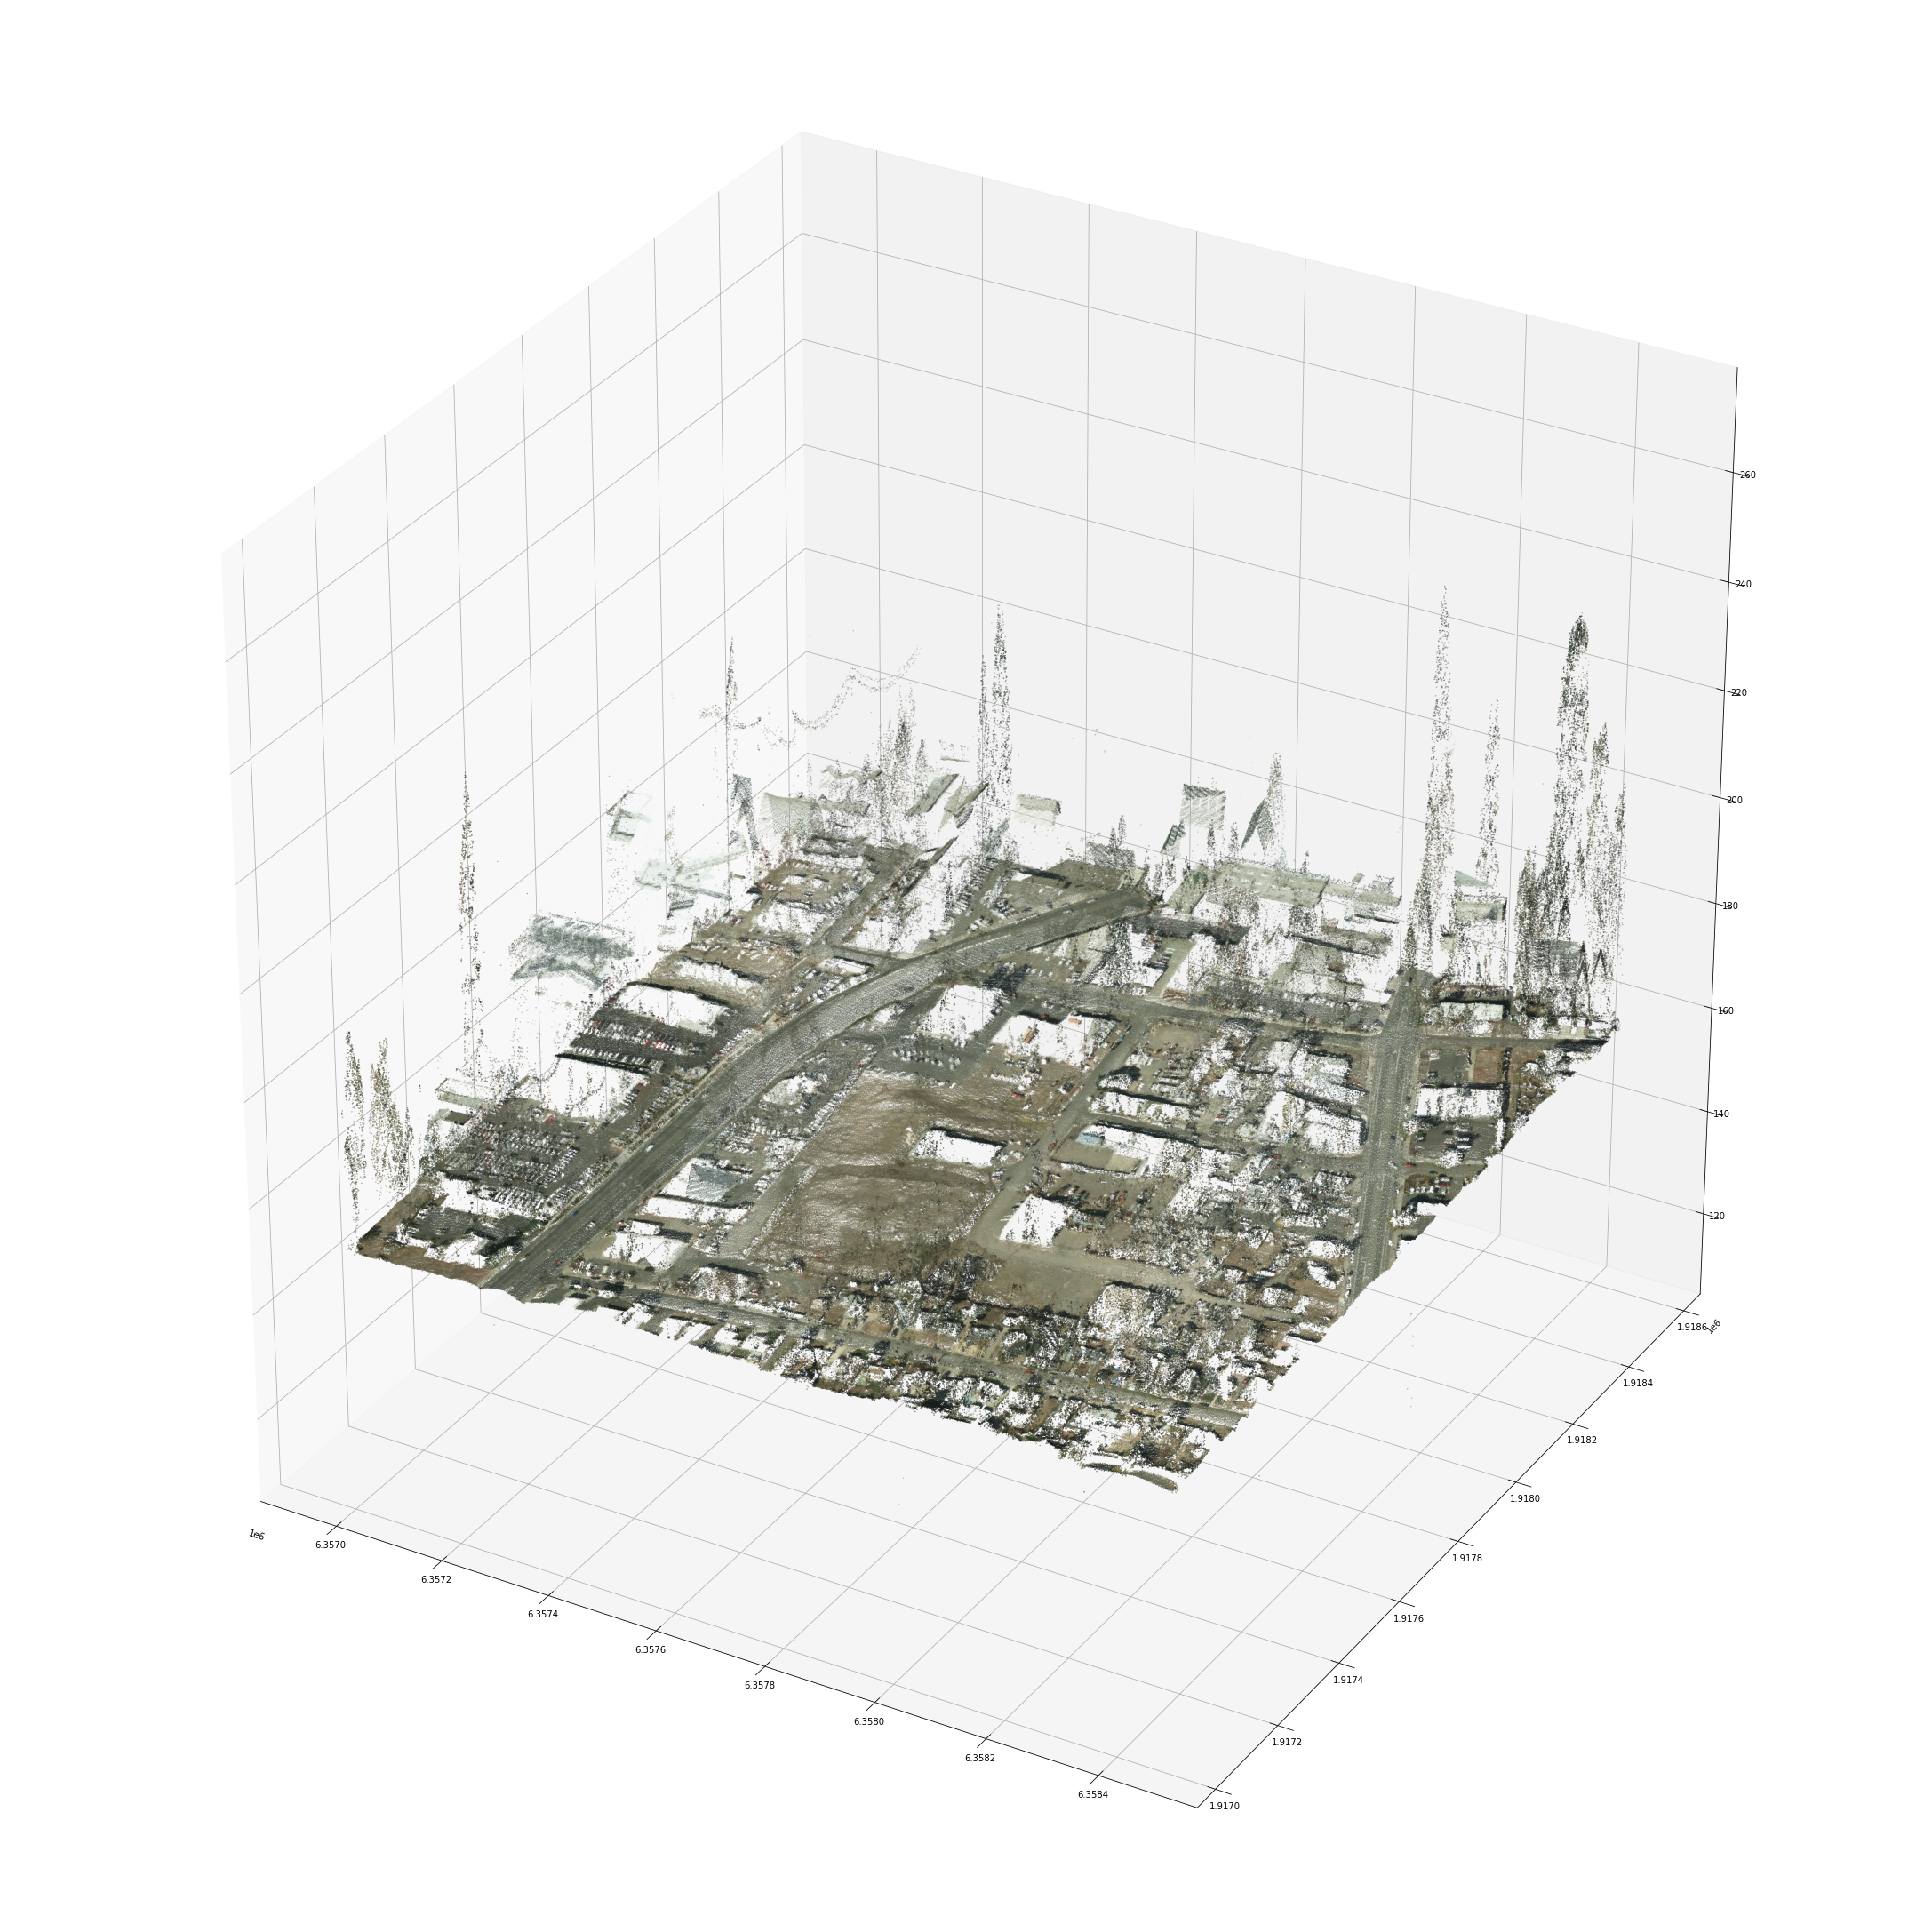

In [ ]:
fig = plt.figure(figsize=[15,15])
ax = fig.add_axes([0,0,2,2],projection='3d')
ax.scatter(*(xyz.T), s = 0.1, c=rgb)
plt.show()

# utilize the attributes of return_num and num_returns to filter ground points

In [ ]:
from lyutool.lyufunc import *

In [ ]:
num_returns = inFile.num_returns
return_num = inFile.return_num
idx = num_returns != return_num
lp_nonground = generateLPByIDS(idx)
idx = num_returns == return_num
lp_ground = generateLPByIDS(idx)
#
kwargs = {'LP': lp_nonground, 'POINTS':xyz}
pts_nonground = getPointsFromSource(**kwargs)
kwargs = {'LP': lp_nonground, 'POINTS':rgb}
rgb_nonground = getPointsFromSource(**kwargs)
#
kwargs = {'LP': lp_ground, 'POINTS':xyz}
pts_ground = getPointsFromSource(**kwargs)
kwargs = {'LP': lp_ground, 'POINTS':rgb}
rgb_ground = getPointsFromSource(**kwargs)

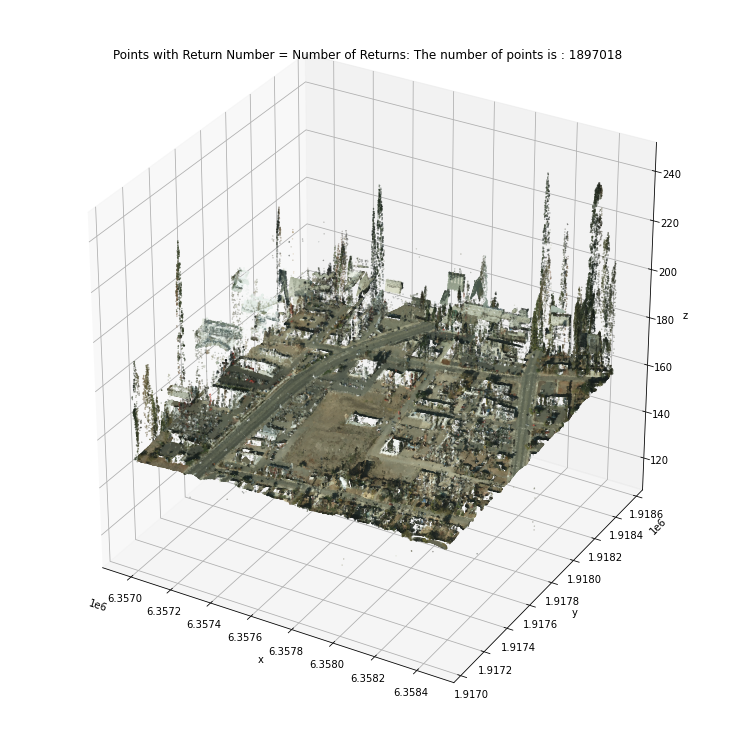

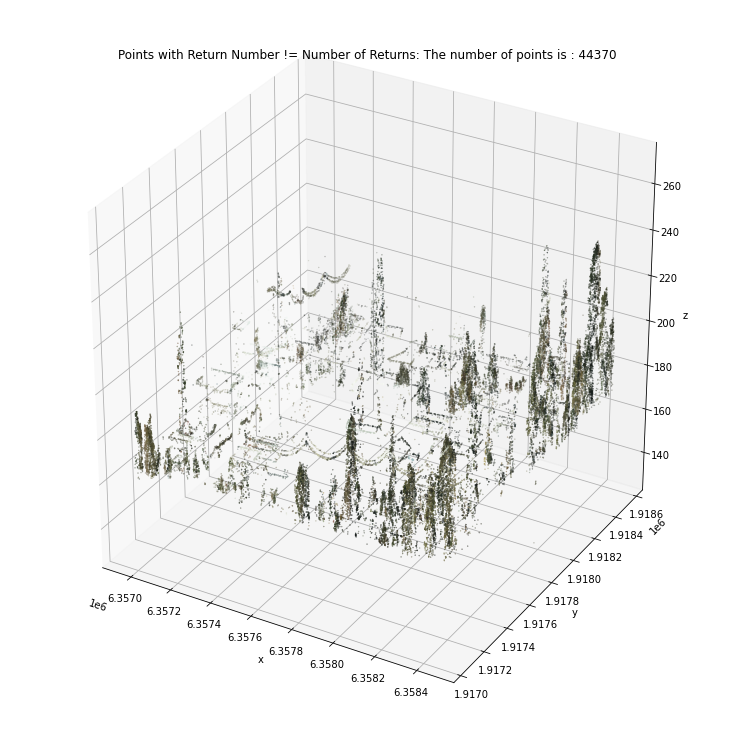

In [ ]:
ax = show(pts_ground,rgb_ground)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Points with Return Number = Number of Returns: The number of points is : %s' % len(pts_ground))
# lot Non-ground Points
ax = show(pts_nonground,rgb_nonground)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Points with Return Number != Number of Returns: The number of points is : %s' % len(pts_nonground))
plt.show()

In [ ]:
idx = np.logical_and(xyz[:,2]>180, num_returns != return_num)
lp_m180 = generateLPByIDS(idx)
kwargs = {'LP': lp_m180, 'POINTS':xyz}
pts_m180 = getPointsFromSource(**kwargs)
kwargs = {'LP': lp_m180, 'POINTS':rgb}
rgb_m180 = getPointsFromSource(**kwargs)

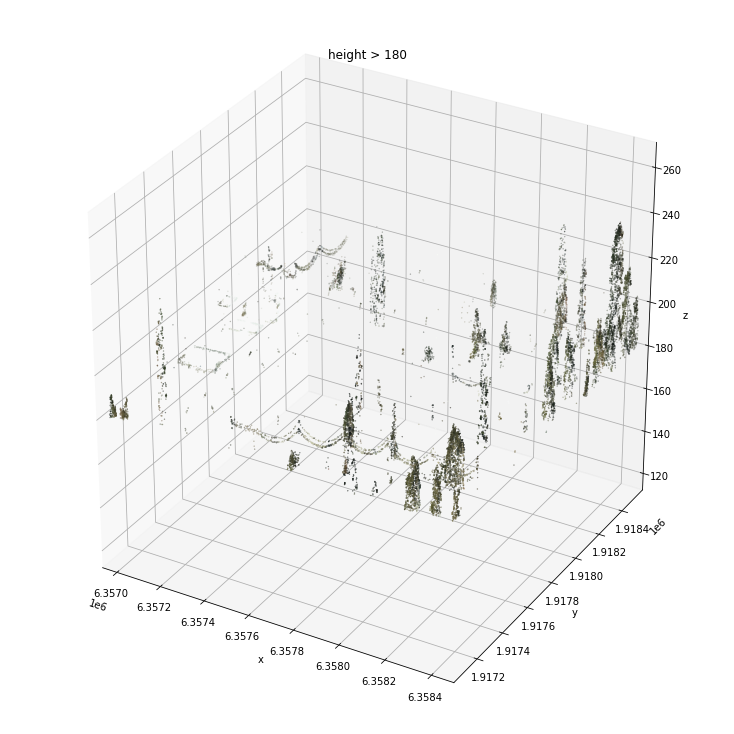

In [ ]:
ax = show(pts_m180,rgb_m180)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('height > 180')
ax.set_xlim(xyz_min[0],xyz_max[0])
ax.set_ylim(xyz_min[1],xyz_max[1])
ax.set_zlim(xyz_min[2],xyz_max[2])
plt.show()

In [ ]:
cf = inFile.classification
con = np.logical_and(cf != 5, cf !=6)
con = np.logical_and(con, num_returns != return_num)
con = np.logical_and(con, xyz[:,2]>180)
lp_un = generateLPByIDS(con)
kwargs = {'LP': lp_un, 'POINTS':xyz}
pts_un = getPointsFromSource(**kwargs)
kwargs = {'LP': lp_un, 'POINTS':rgb}
rgb_un = getPointsFromSource(**kwargs)
pts_un.shape

(1992, 3)

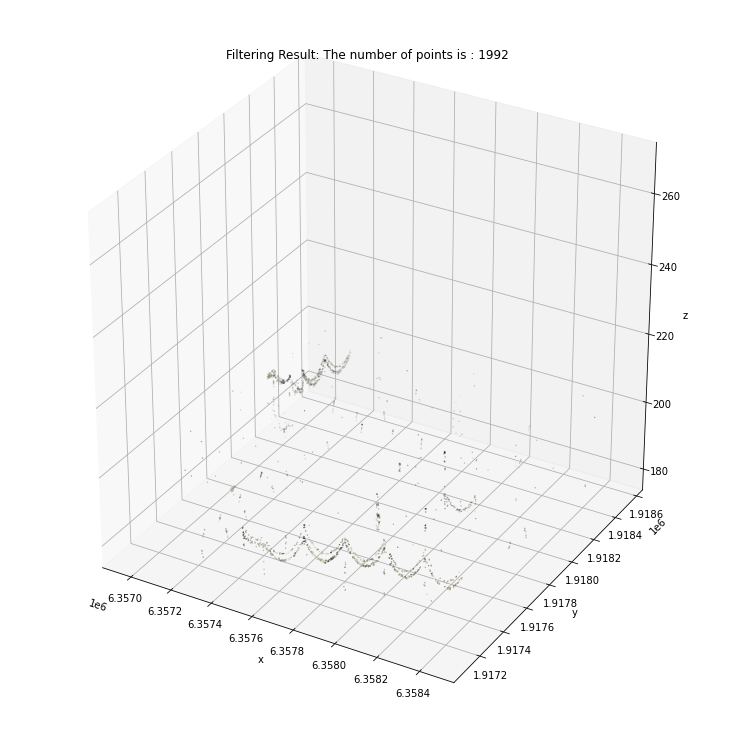

In [ ]:
ax = show(pts_un,rgb_un)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('Filtering Result: The number of points is : %s' % len(pts_un))
plt.show()

# construct Quad_tree based on non-ground points

In [ ]:
tree = KDTree(pts_un)

In [ ]:
xyz_min = np.min(xyz, axis=0)
xyz_max = np.max(xyz, axis=0)

# evaluate the sphericity, planarity, and linearity for each point

In [ ]:
features = []
pca = PCA(n_components=3)
n = 50
for i in tqdm(range(pts_un.shape[0])):
    di = tree.query(pts_un[i], k=n)
    pts = pts_un[di[1]]
    pca.fit(pts)
    a = {'points': pts, 'pca': pca}
    fts = extractFeathersByPointCloud(**a)
    r = fts['radius']
    al = fts['axis']
    sp = fts['sphericity']
    ln = fts['linearity']
    pl = fts['planarity']
    # add Height information
    height = abs(pts_un[i][2] - xyz_min[2])
    features.append([r, al, sp, ln, pl, height])
#
features = np.array(features)
features.shape

100%|██████████| 1992/1992 [00:03<00:00, 593.14it/s]


(1992, 6)

# use the dataset including sphericity, planarity and linearity to train GMM classifer. Supposed to be two classes: line and non-line, GMM divided dataset into 2 classes.

In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler

In [ ]:
cov_type = 'full'
n_classes = 2
gm = GaussianMixture(n_components=n_classes,
              covariance_type=cov_type, max_iter=120, random_state=0)
#
gm.fit(features)
y_train_pred = gm.predict(features)

In [ ]:
idx_un = np.array(list(lp_un.dic.values()))

c0 = idx_un[y_train_pred == 0]
c1 = idx_un[y_train_pred == 1]

idx = np.zeros(xyz.shape[0],dtype=bool)
idx[c0] = True
lp_0 = generateLPByIDS(idx)

idx = np.zeros(xyz.shape[0],dtype=bool)
idx[c1] = True
lp_1 = generateLPByIDS(idx)

kwargs = {'LP': lp_0, 'POINTS':xyz}
pts_0 = getPointsFromSource(**kwargs)
kwargs = {'LP': lp_0, 'POINTS':rgb}
rgb_0 = getPointsFromSource(**kwargs)

kwargs = {'LP': lp_1, 'POINTS':xyz}
pts_1 = getPointsFromSource(**kwargs)
kwargs = {'LP': lp_1, 'POINTS':rgb}
rgb_1 = getPointsFromSource(**kwargs)
f'pts_0:{pts_0.shape[0]}, pts_1:{pts_1.shape[0]}'

'pts_0:1592, pts_1:400'

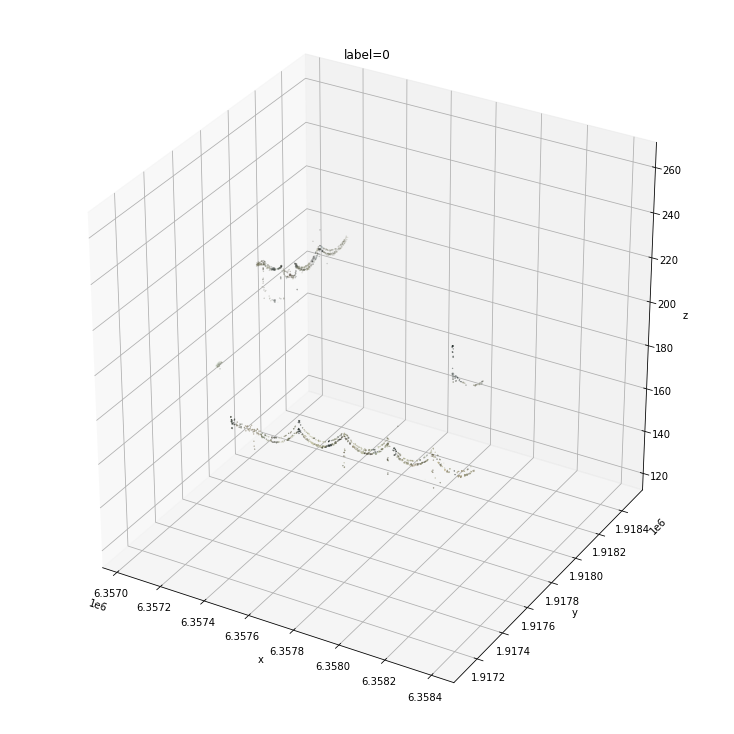

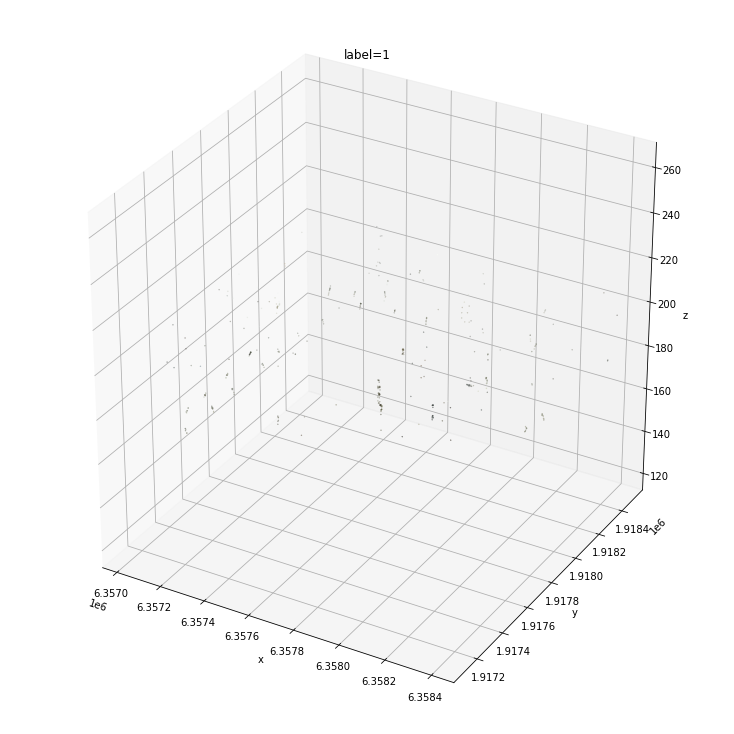

In [ ]:
ax = show(pts_0,rgb_0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('label=0')
ax.set_xlim(xyz_min[0],xyz_max[0])
ax.set_ylim(xyz_min[1],xyz_max[1])
ax.set_zlim(xyz_min[2],xyz_max[2])

ax = show(pts_1,rgb_1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('label=1')
ax.set_xlim(xyz_min[0],xyz_max[0])
ax.set_ylim(xyz_min[1],xyz_max[1])
ax.set_zlim(xyz_min[2],xyz_max[2])
plt.show()

In [ ]:
#
idx = np.zeros(xyz.shape[0],dtype=bool)
c0 = list(lp_1.dic.values())
idx[c0] = True

fp = pathlib.Path('/home/hxl170008/data/temp/t1.las')
outFile = las.file.File(fp, mode = 'w', header = inFile.header)
outFile.points = inFile.points[idx]
outFile.close()

In [ ]:
xyz_max - xyz_min

array([1499.97, 1499.97,  152.52])

# transform the points in the Figure 2 to a raster image.

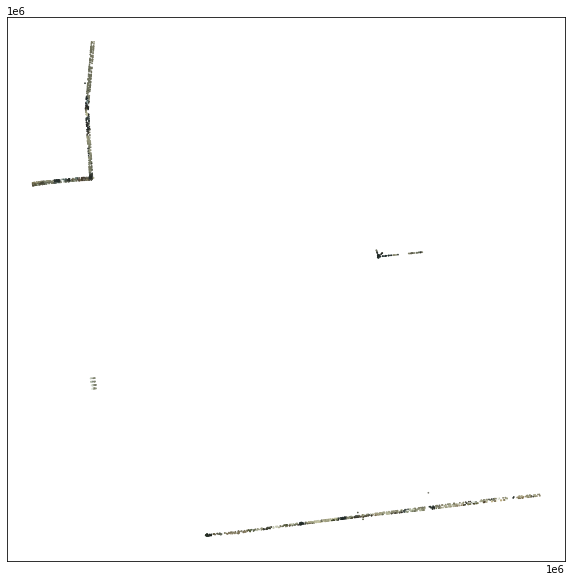

In [ ]:
sides = ('left', 'right', 'top', 'bottom')
nolabels = {s: False for s in sides}
nolabels.update({'label%s' % s: False for s in sides})
%matplotlib inline

fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.scatter(*zip(pts_0[:,0:2].T), s=0.5, c= rgb_0)
ax.tick_params(axis='both', which='both', **nolabels)

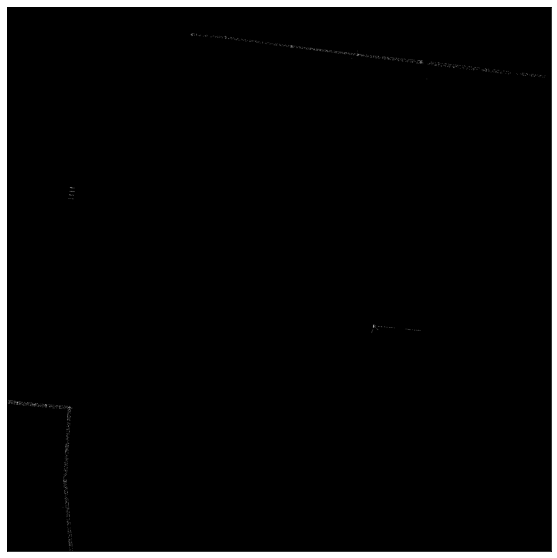

In [ ]:
a = {'min_xyz':xyz_min, 'max_xyz':xyz_max, 'pts':pts_0, 'cellsize':1}
img_xy = pointsToRaster(**a) # rtn
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.tick_params(axis='both', which='both', **nolabels)
ax.imshow(img_xy, cmap='gray')
plt.show()

In [ ]:
from skimage.transform import hough_line, hough_line_peaks

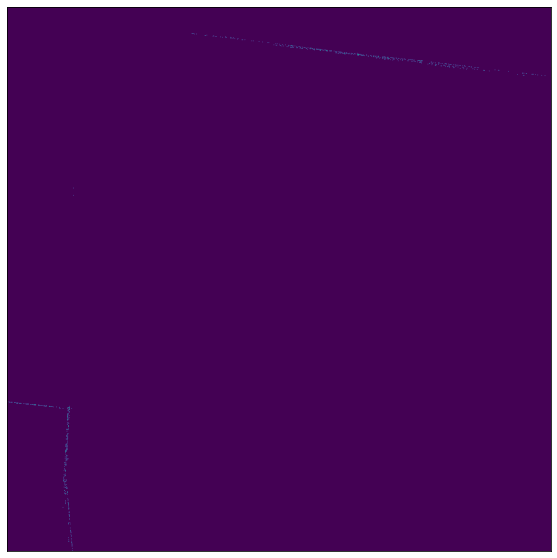

In [ ]:
# Hough transform
threshold_line = 40
maxdist = 1
tested_angles = np.linspace(0, 2*np.pi, 360)
h, theta, d = hough_line(img_xy, theta = tested_angles)
hough_peaks = hough_line_peaks(h, theta, d, threshold=threshold_line)
# filter the short lines based on hough peaks and raster image img_xy
a = {'img': img_xy, 'peaks':zip(*hough_peaks), 'maxdist':maxdist}
img_base = houghToRasterByCellID(**a) # rtn
#
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.tick_params(axis='both', which='both', **nolabels)
ax.imshow(img_base)
plt.show()

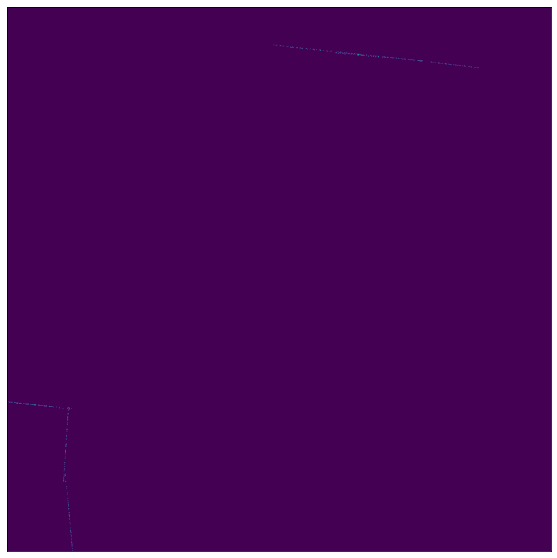

In [ ]:
a = {'xyz_min': xyz_min,
     'xyz_max': xyz_max,
     'points' : pts_0,
     'cellsize': 1,
     'HF_peaks_threshold': 40,
     'maxdist': 1,
     'discontinuity_threshold': 70,
     'buffer_size': 4
    }
rtn = constructCorridorsByHT(**a)
img_xy = rtn['img_xy']
img_corridors = rtn['img_corridors']
img_base = rtn['img_base']
lid = rtn['discontinuity']
img_lines = rtn['img_lines']
corridors = rtn['corridors'] 
hl = rtn['hough_lines']
#
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.tick_params(axis='both', which='both', **nolabels)
ax.imshow(img_lines)

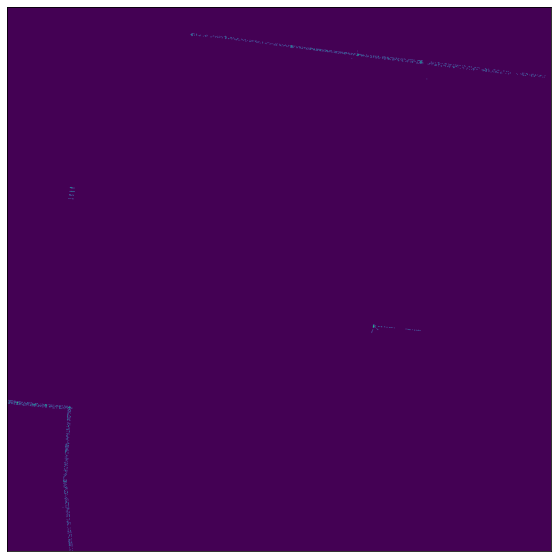

In [ ]:
# the original raster image generated from the points cloud with self-defined cell size.
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.tick_params(axis='both', which='both', **nolabels)
ax.imshow(img_xy)

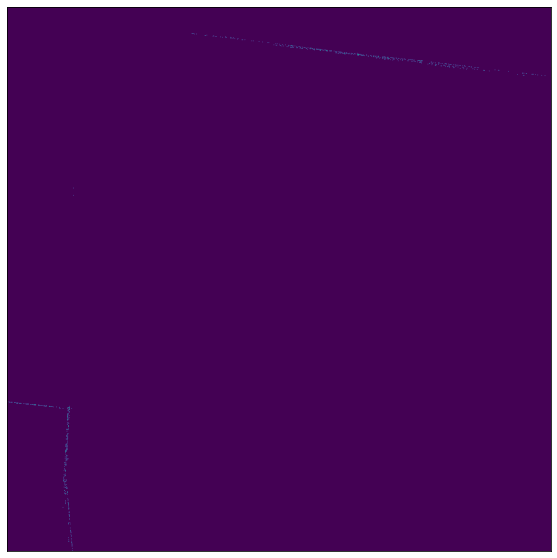

In [ ]:
# filter the short lines based on hough peaks and raster image img_xy
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.tick_params(axis='both', which='both', **nolabels)
ax.imshow(img_base)

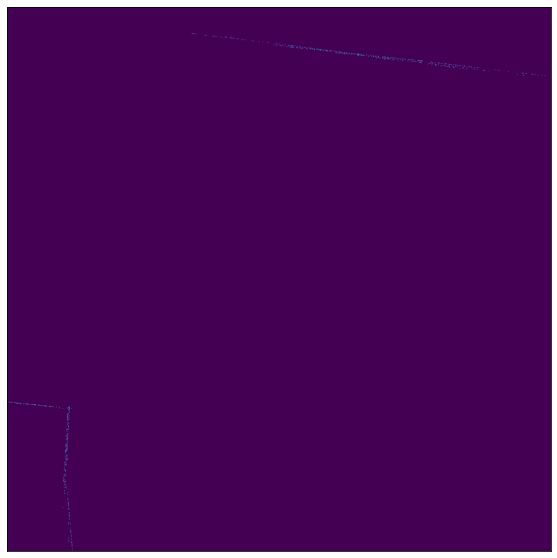

In [ ]:
# remove the lines with long discontinuity
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.tick_params(axis='both', which='both', **nolabels)
ax.imshow(img_lines)

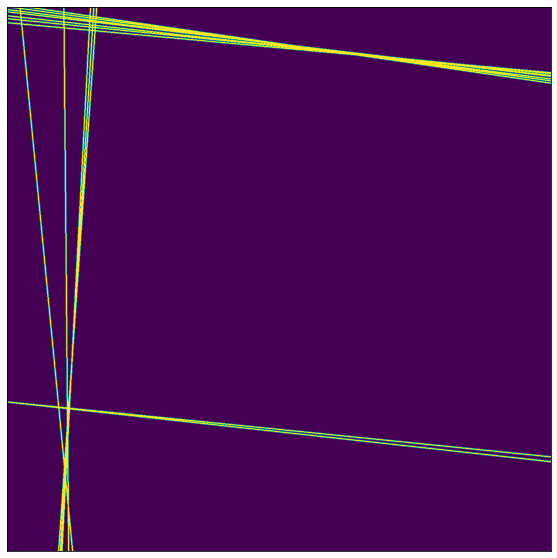

In [ ]:
# construct corridors based on img_temp and buffer operation
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.tick_params(axis='both', which='both', **nolabels)
ax.imshow(img_corridors)

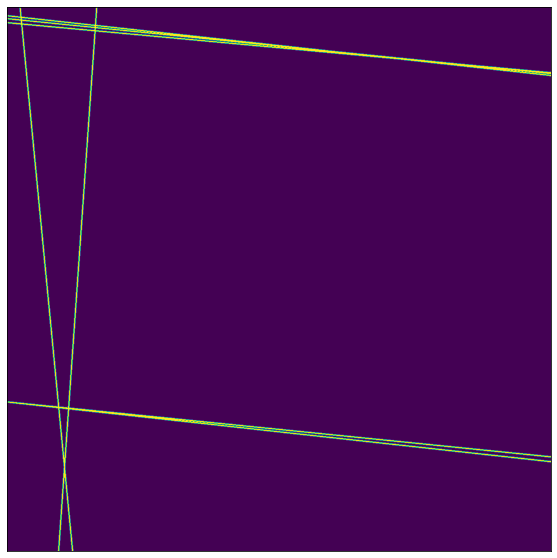

In [ ]:
# threshold = 70
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.tick_params(axis='both', which='both', **nolabels)
ax.imshow(img_corridors)

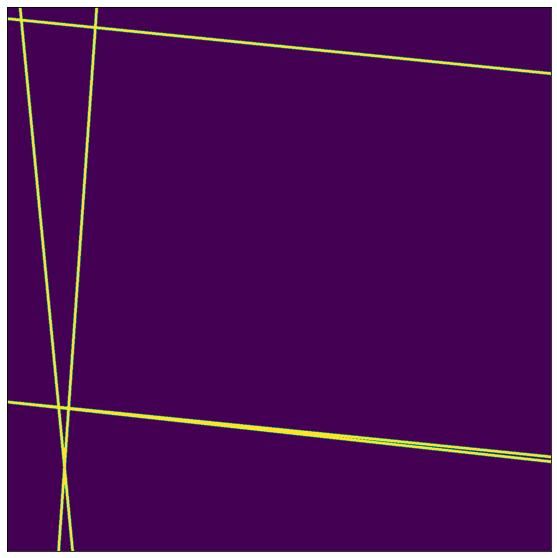

In [ ]:
#threshold = 50
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.tick_params(axis='both', which='both', **nolabels)
ax.imshow(img_corridors)

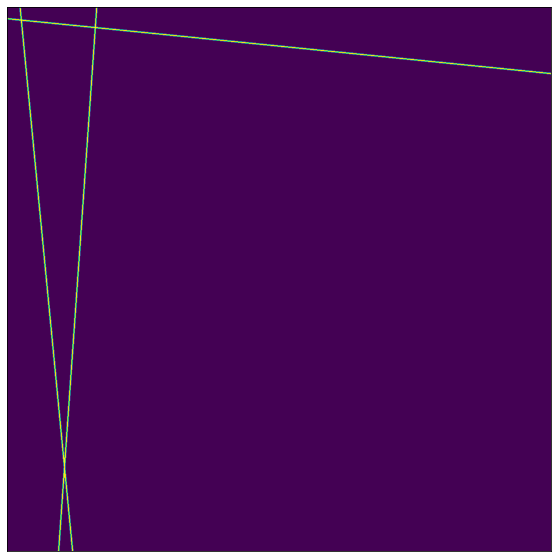

In [ ]:
#threshold = 40
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.tick_params(axis='both', which='both', **nolabels)
ax.imshow(img_corridors)

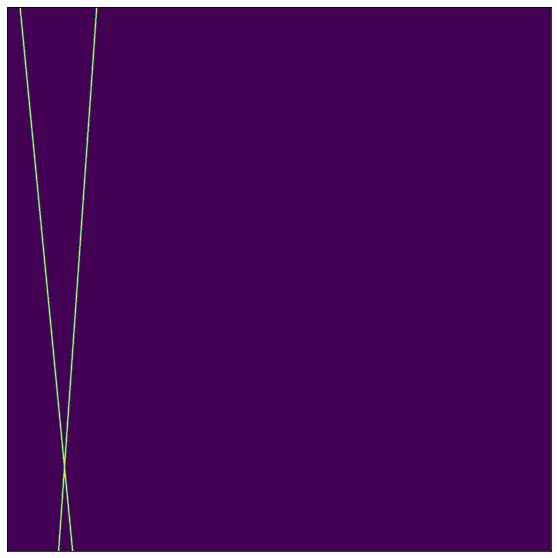

In [ ]:
#threshold = 30
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.tick_params(axis='both', which='both', **nolabels)
ax.imshow(img_corridors)

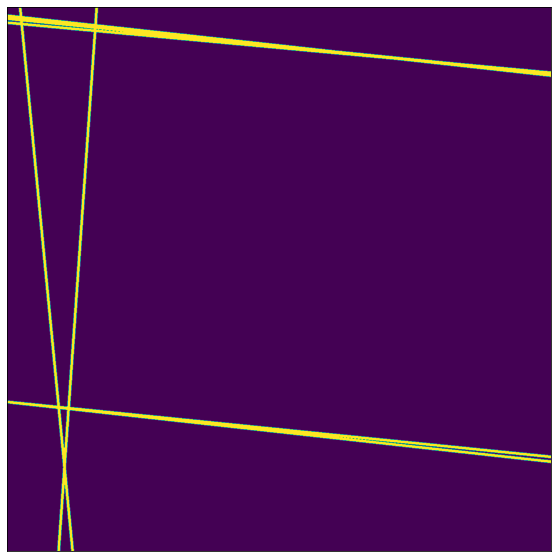

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.tick_params(axis='both', which='both', **nolabels)
ax.imshow(img_corridors)

In [ ]:
imgs = np.sum(corridors, axis=0)
seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize']
data = (imgs, xyz_min, pts_0, 1)
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
pids = locatePointsFromBuffer(**a) 
len(pids)

1041

In [ ]:
seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize']
data = (img_corridors, xyz_min, pts_0, 1)
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
pids = locatePointsFromBuffer(**a) 
len(pids)

1041

In [ ]:
img_corridors_50 = img_corridors

In [ ]:
idx = np.zeros(xyz.shape[0], dtype=bool)
c = np.array(list(lp_0.dic.values()))
c = c[pids]
idx[c] = True
lp_end = generateLPByIDS(idx)

kwargs = {'LP': lp_end, 'POINTS':xyz}
pts_end = getPointsFromSource(**kwargs)
kwargs = {'LP': lp_end, 'POINTS':rgb}
rgb_end = getPointsFromSource(**kwargs)
pts_end.shape

(1041, 3)

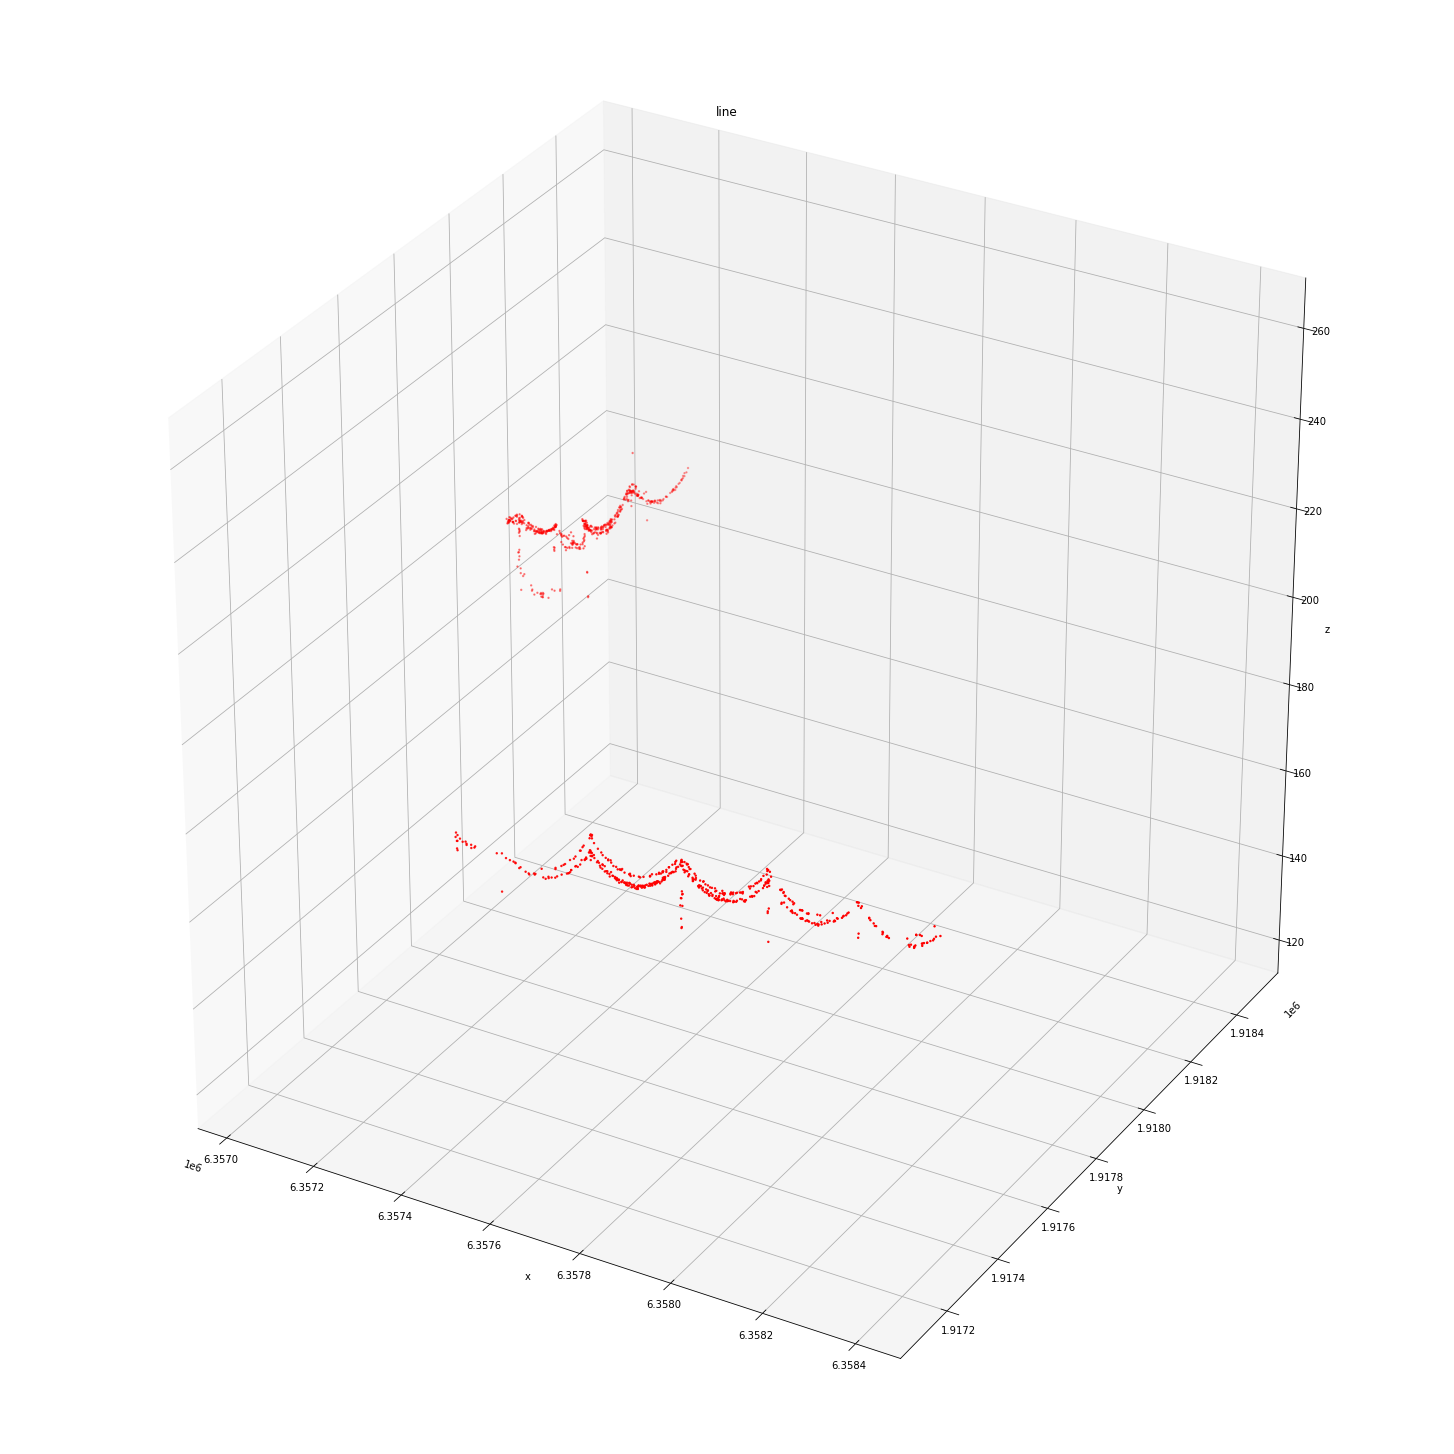

In [ ]:
#ax = show(pts_end,rgb_end)
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,2,2],projection='3d')
ax.scatter(*(pts_end.T), s=2, c='red')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('line')
ax.set_xlim(xyz_min[0],xyz_max[0])
ax.set_ylim(xyz_min[1],xyz_max[1])
ax.set_zlim(xyz_min[2],xyz_max[2])
plt.show()

In [ ]:
# export the result to las file
idx = np.zeros(xyz.shape[0],dtype=bool)
c0 = list(lp_end.dic.values())
idx[c0] = True

fp = pathlib.Path('/home/hxl170008/data/temp/line_124.las')
outFile = las.file.File(fp, mode = 'w', header = inFile.header)
outFile.points = inFile.points[idx]
outFile.close()

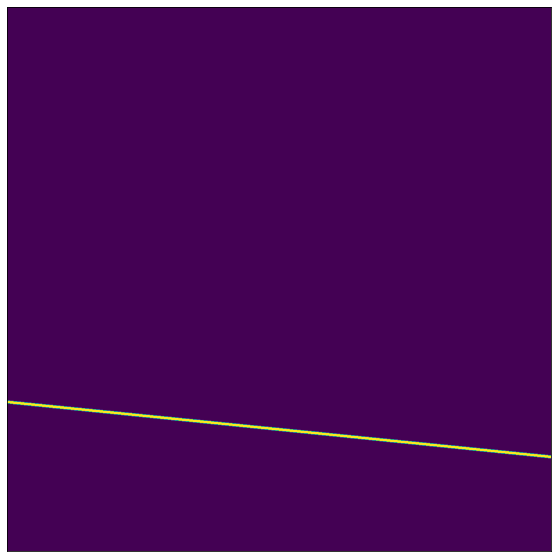

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.gca()
ax.tick_params(axis='both', which='both', **nolabels)
ax.imshow(corridors[4])

In [ ]:
pids = []
seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize']
for i in [0,1,5]:
    data = (corridors[i], xyz_min, pts_0, 1)
    a = dict.fromkeys(seq)
    for k, v in zip(seq, data):
        a[k] = v
    pid = locatePointsFromBuffer(**a)
    pids = pids + pid
#
len(pids)

1140

In [ ]:
len(np.unique(pids))

519

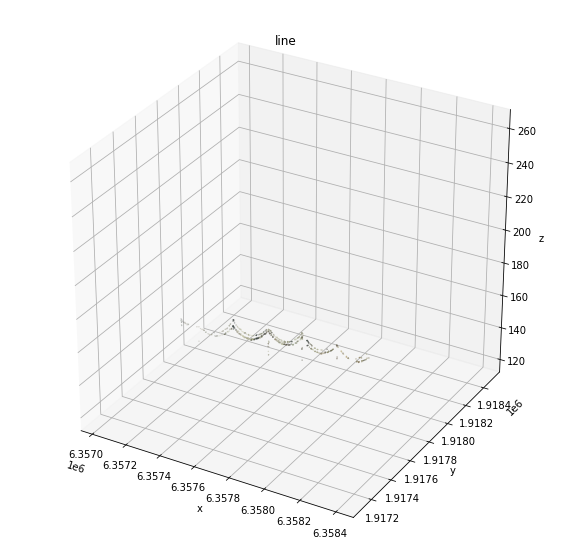

In [ ]:
idx = np.zeros(xyz.shape[0], dtype=bool)
c = np.array(list(lp_0.dic.values()))
c = c[pids]
idx[c] = True
lp_t1 = generateLPByIDS(idx)

kwargs = {'LP': lp_t1, 'POINTS':xyz}
pts_t1 = getPointsFromSource(**kwargs)
kwargs = {'LP': lp_t1, 'POINTS':rgb}
rgb_t1 = getPointsFromSource(**kwargs)
#
ax = show(pts_t1,rgb_t1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('line')
ax.set_xlim(xyz_min[0],xyz_max[0])
ax.set_ylim(xyz_min[1],xyz_max[1])
ax.set_zlim(xyz_min[2],xyz_max[2])
plt.show()

In [ ]:
print(np.min(pts_t1, axis=0))
print(np.max(pts_t1, axis=0))
np.mean(pts_t1, axis=0)
#
line_mean = pts_t1.copy()
line_mean[:,2] = np.mean(pts_t1[:,2])
line_max  = pts_t1.copy()
line_max[:,2] = np.max(pts_t1[:,2])
line_bottom = pts_t1.copy()
line_bottom[:,2] = np.mean(pts_t1[:,2]) - 6

[6.35747268e+06 1.91712773e+06 1.80280000e+02]
[6.35844830e+06 1.91724095e+06 1.98420000e+02]


(115.29, 267.81)

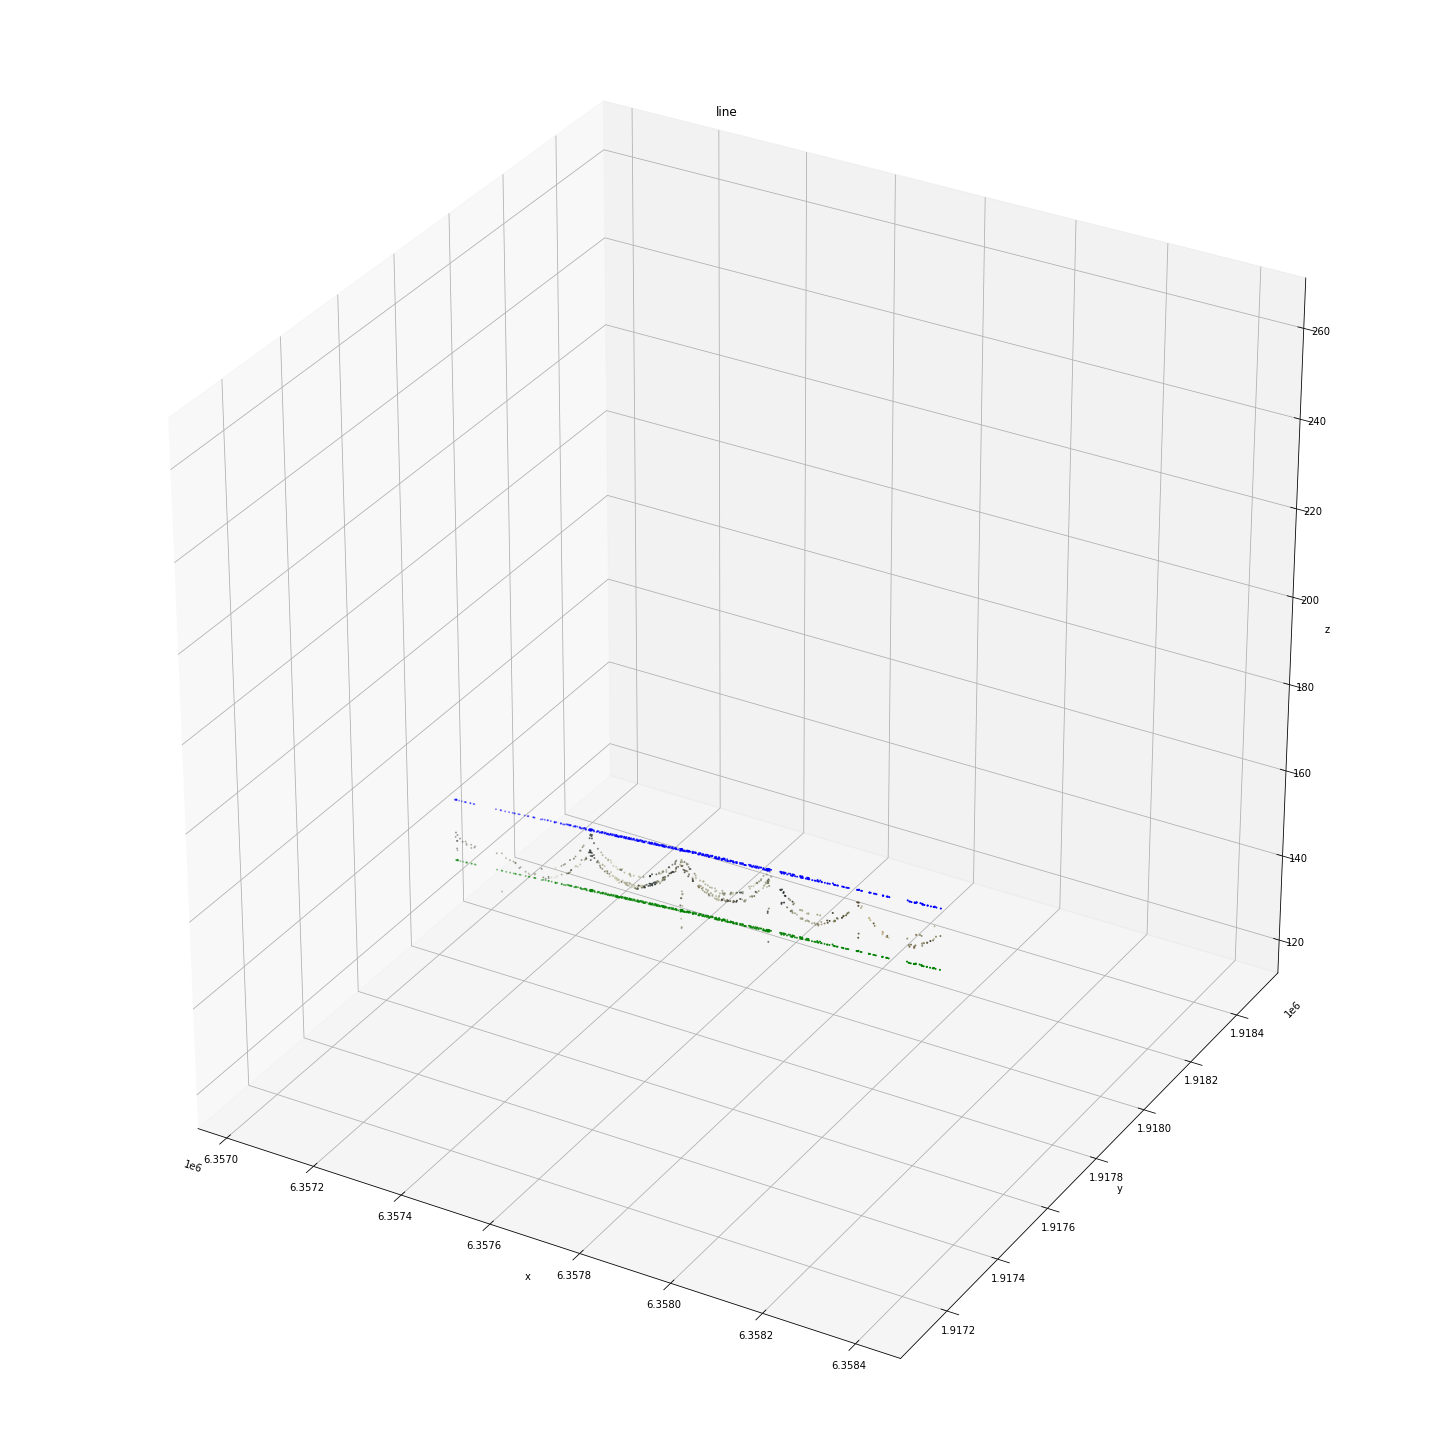

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,2,2],projection='3d')
ax.scatter(*(pts_t1.T), s=1, c= rgb_t1)
#
#ax.scatter(*(line_mean.T), s=1, c='red')
ax.scatter(*(line_max.T), s=1, c='blue')
ax.scatter(*(line_bottom.T), s=1, c='green')
#
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('line')
ax.set_xlim(xyz_min[0],xyz_max[0])
ax.set_ylim(xyz_min[1],xyz_max[1])
ax.set_zlim(xyz_min[2],xyz_max[2])

In [ ]:
def locatePointsFromBuffer_3D(**kwargs):
    """
    Description: obtain points from original point cloud base on the image buffer in 3D space
    
                self-defined the range of Z axis (Height) is used.
    
    """
    img_buffer = kwargs['img_buffer']
    min_xyz = kwargs['min_xyz']
    pts = kwargs['pts']
    cellsize = kwargs['cellsize']
    zrange = kwargs['zrange'] # [z_min, z_max]
    z_min, z_max = zrange
    #
    ly, lx = np.nonzero(img_buffer)
    x_min, y_min = min_xyz[0:2]
    px = cellsize * lx + x_min
    py = cellsize * ly + y_min
    nid_line=[]
    zipped = zip(px,py)
    for i,j in zipped:
        fcx = np.logical_and(pts[:,0] >= i, pts[:,0] < (i + cellsize))
        fcy = np.logical_and(pts[:,1] >= j, pts[:,1] < (j + cellsize))
        fcz = np.logical_and(pts[:,2] >= z_min, pts[:,2] <= z_max)
        idx = np.logical_and(fcx, fcy)
        idx = np.logical_and(idx, fcz)
        a = np.argwhere(idx==True)
        a = a.ravel()
        nid_line = nid_line + a.tolist()
    return nid_line

In [ ]:
imgs = np.sum(corridors,axis=0)
seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize', 'zrange']
zmin = np.mean(pts_t1[:,2]) - 6
zmax = np.max(pts_t1[:,2]) 
data = (imgs, xyz_min, pts_un, 1, [zmin,zmax])
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
pids = locatePointsFromBuffer_3D(**a)
len(pids)

1010

In [ ]:
np.unique(pids).shape

(519,)

In [ ]:
b = corridors[0]+corridors[1]+corridors[5]
seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize']
data = (b, xyz_min, pts_0, 1)
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
pids = locatePointsFromBuffer(**a) 
len(pids)

519

In [ ]:
a = pts_0[pids,2]
dz = calOutlierByIQR(a)
b = corridors[0]+corridors[1]+corridors[5]
seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize', 'zrange']
zmin = dz['lower_inner_fence']
zmax = dz['upper_inner_fence']
data = (b, xyz_min, pts_un, 1, [zmin,zmax])
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
pids = locatePointsFromBuffer_3D(**a)
len(pids)

510

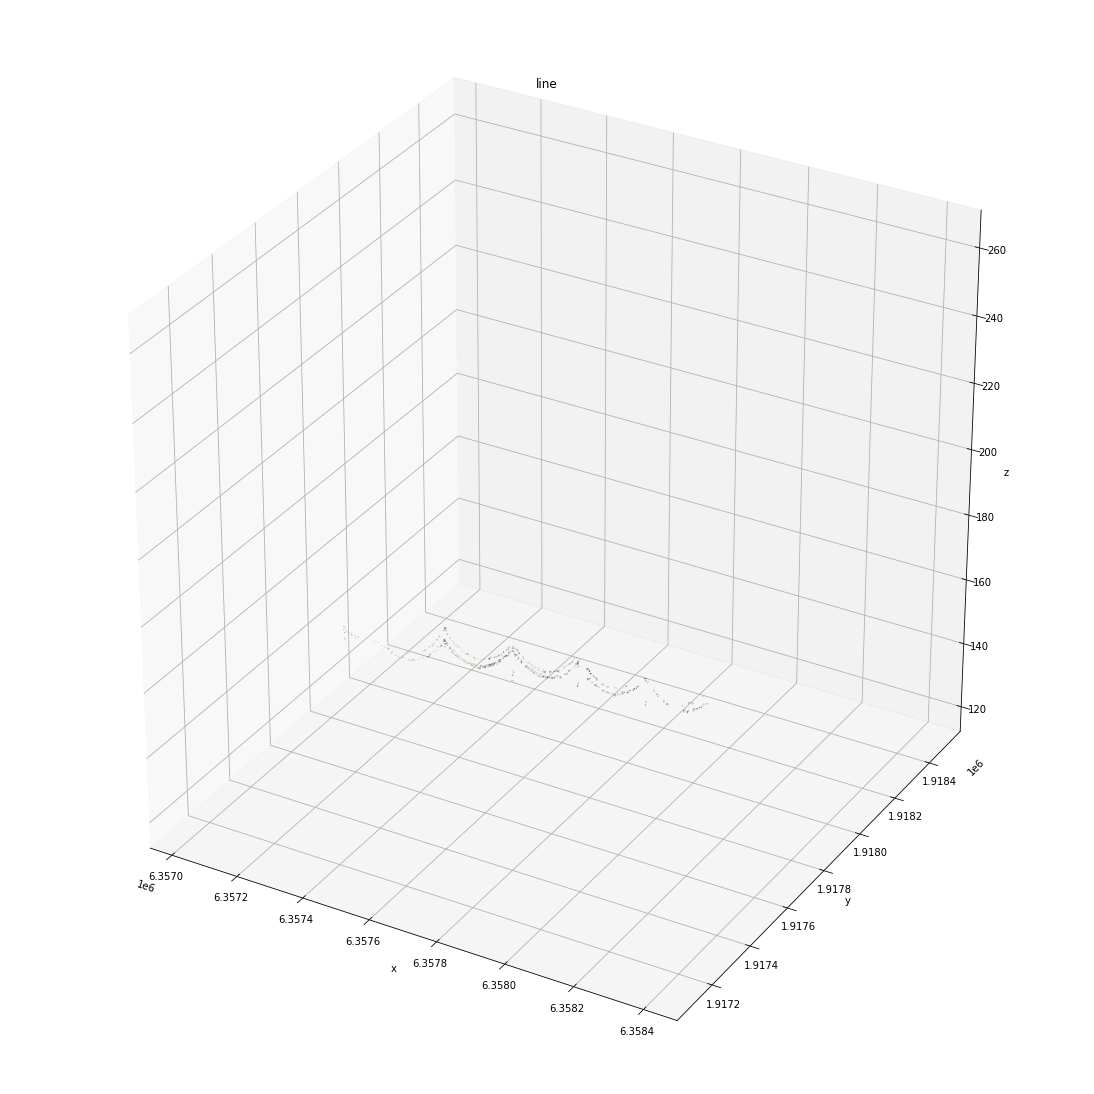

In [ ]:
idx = np.zeros(xyz.shape[0], dtype=bool)
c = np.array(list(lp_un.dic.values()))
c = c[pids]
idx[c] = True
lp_t1 = generateLPByIDS(idx)

kwargs = {'LP': lp_t1, 'POINTS':xyz}
pts_t1 = getPointsFromSource(**kwargs)
kwargs = {'LP': lp_t1, 'POINTS':rgb}
rgb_t1 = getPointsFromSource(**kwargs)
#
ax = show(pts_t1,rgb_t1)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('line')
ax.set_xlim(xyz_min[0],xyz_max[0])
ax.set_ylim(xyz_min[1],xyz_max[1])
ax.set_zlim(xyz_min[2],xyz_max[2])
plt.show()

In [ ]:
seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize']
pts_border = pts_0.copy()
b = corridors[0]+corridors[1]+corridors[5]
data = (b, xyz_min, pts_border, 1)
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
#
pts_border = generateLineBordersByBuffer(**a)
pts_border.shape

(519, 5)

In [ ]:
p = np.unique(pts_border, axis=0)
#p[:,4] = p[:,4] + 1
#p[:,3] = p[:,3] - 1
p.shape

(519, 5)

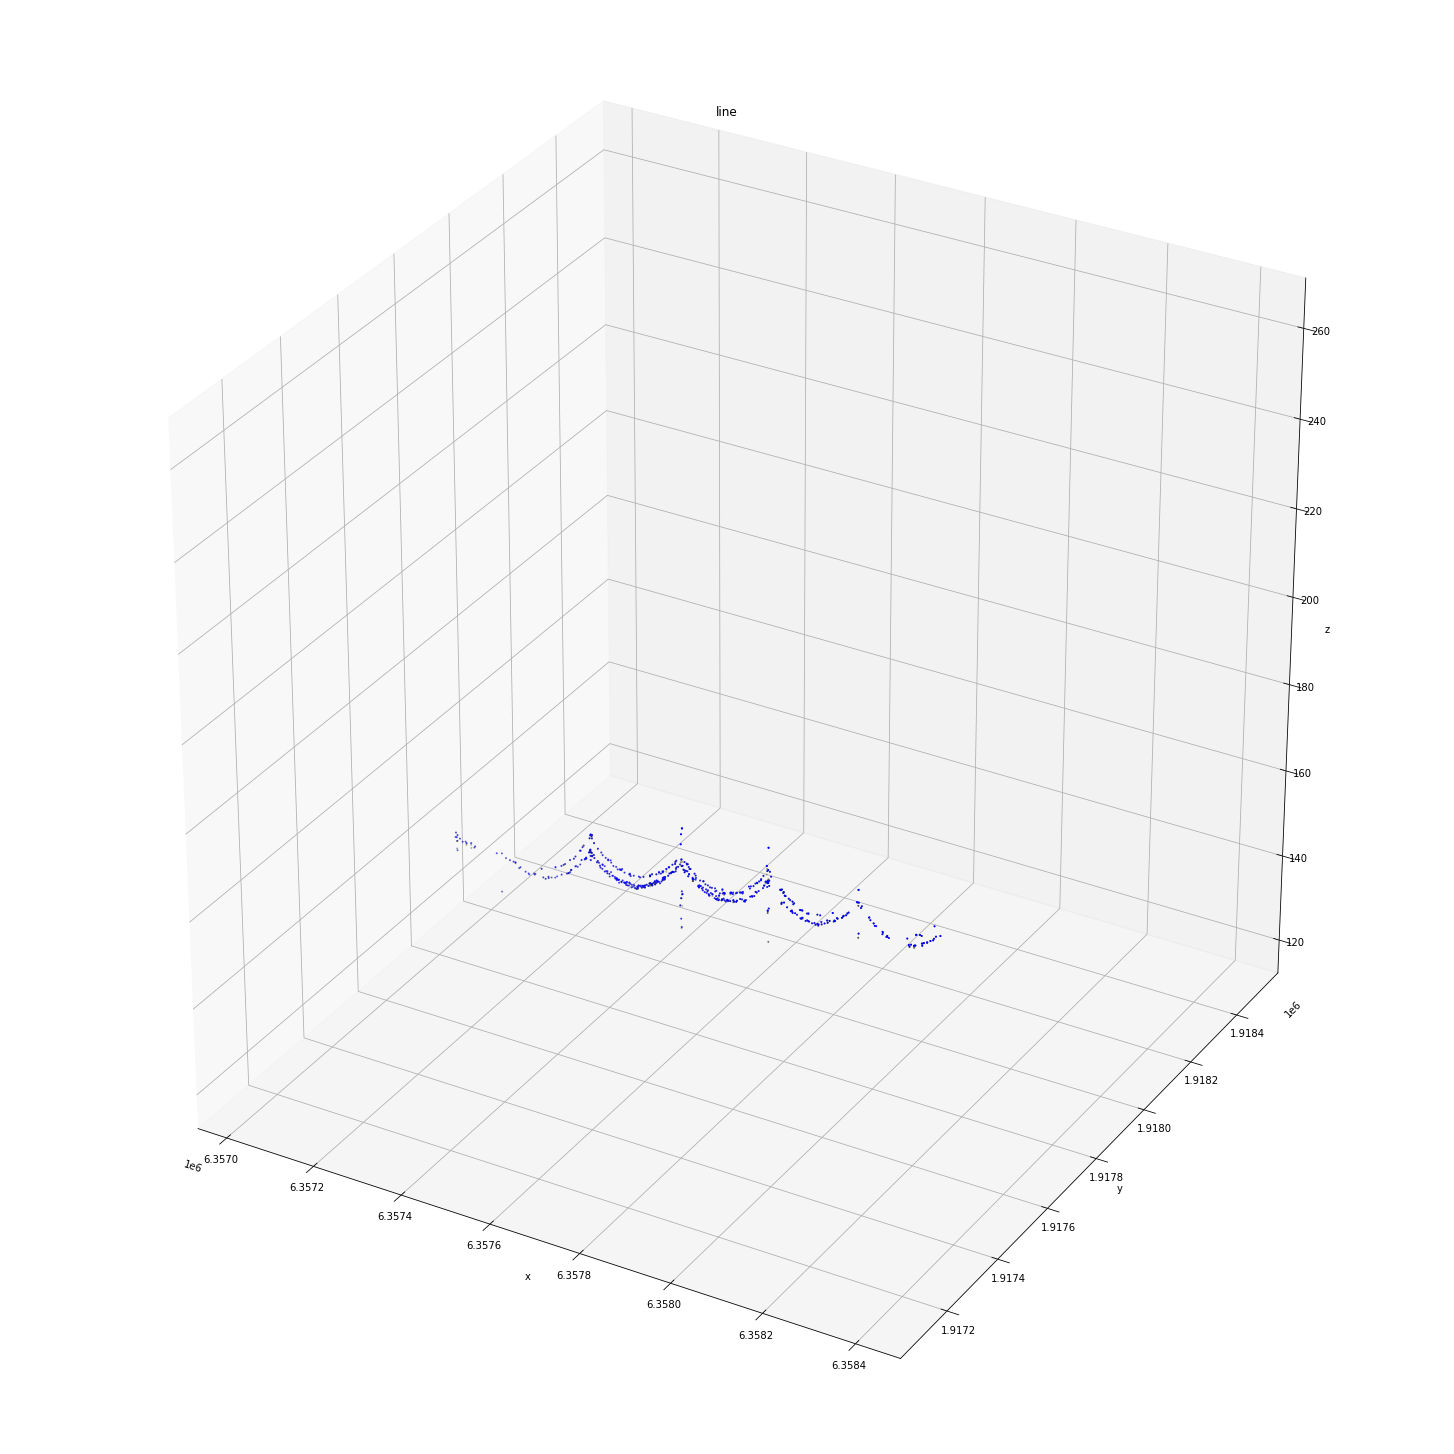

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,2,2],projection='3d')
ax.scatter(*(pts_t1.T), s=1, c= rgb_t1)
#
#ax.scatter(*(line_mean.T), s=1, c='red')
ax.scatter(*(p[:,[0,1,4]].T), s=1, c='blue')
#ax.scatter(*(p[:,[0,1,3]].T), s=1, c='green')
#
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('line')
ax.set_xlim(xyz_min[0],xyz_max[0])
ax.set_ylim(xyz_min[1],xyz_max[1])
ax.set_zlim(xyz_min[2],xyz_max[2])
plt.show()

In [ ]:
b = corridors[2]+corridors[4]
seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize']
data = (b, xyz_min, pts_0, 1)
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
pids = locatePointsFromBuffer(**a) 
len(pids)

258

In [ ]:
a = pts_0[pids,2]
dz = calOutlierByIQR(a)
b = corridors[2]+corridors[4]
seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize', 'zrange']
zmin = dz['lower_inner_fence']
zmax = dz['upper_inner_fence']
data = (b, xyz_min, pts_un, 1, [zmin,zmax])
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
pids = locatePointsFromBuffer_3D(**a)
len(pids)

217

In [ ]:
idx = np.zeros(xyz.shape[0], dtype=bool)
c = np.array(list(lp_un.dic.values()))
c = c[pids]
idx[c] = True
lp_t2 = generateLPByIDS(idx)

kwargs = {'LP': lp_t2, 'POINTS':xyz}
pts_t2 = getPointsFromSource(**kwargs)
kwargs = {'LP': lp_t2, 'POINTS':rgb}
rgb_t2 = getPointsFromSource(**kwargs)
#


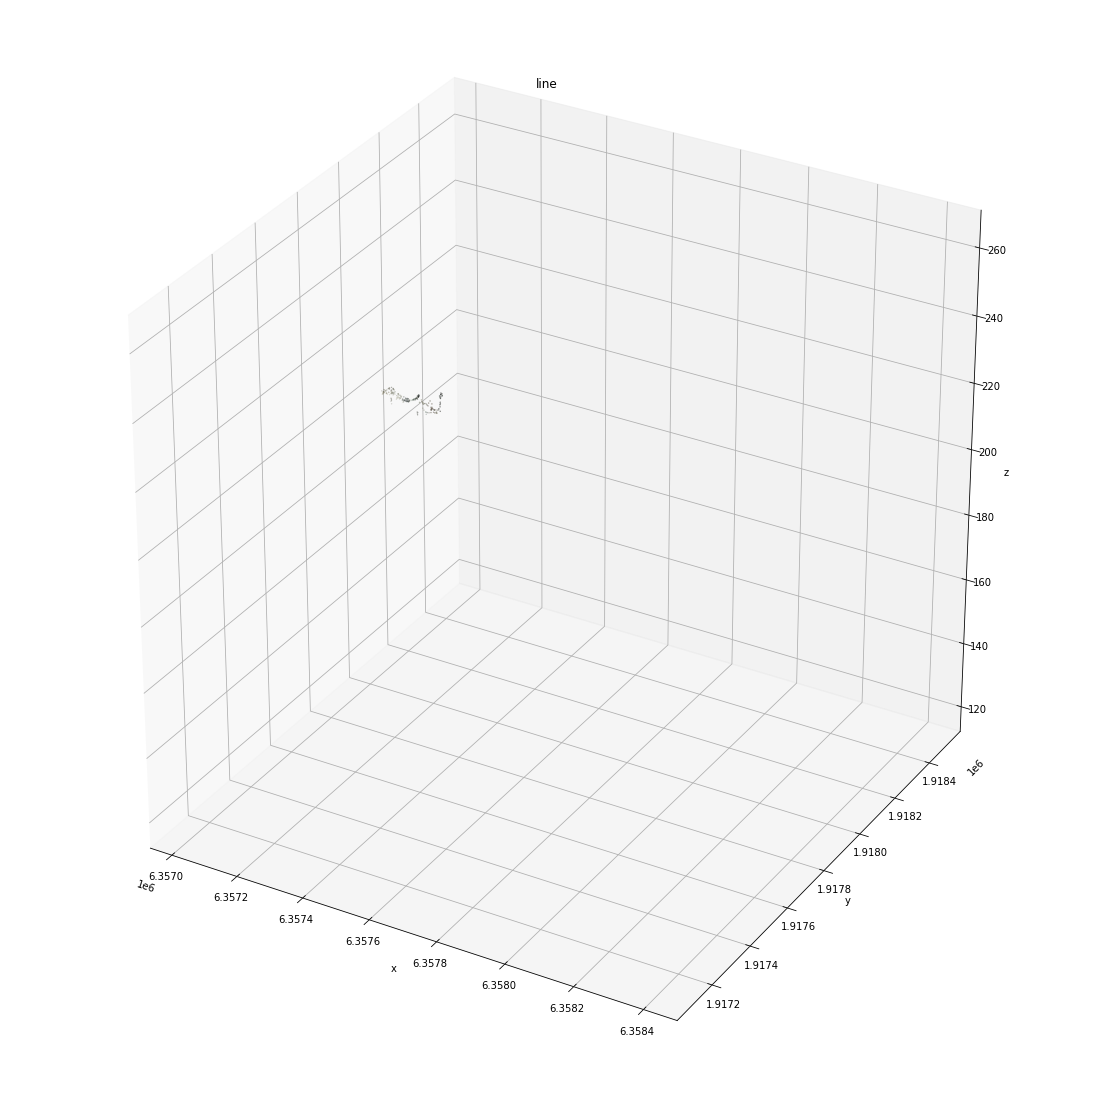

In [ ]:
ax = show(pts_t2,rgb_t2)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('line')
ax.set_xlim(xyz_min[0],xyz_max[0])
ax.set_ylim(xyz_min[1],xyz_max[1])
ax.set_zlim(xyz_min[2],xyz_max[2])
plt.show()

# Line 3

In [ ]:
b = corridors[3]+corridors[6]
seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize']
data = (b, xyz_min, pts_0, 1)
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
pids = locatePointsFromBuffer(**a) 
len(pids)

292

In [ ]:
a = pts_0[pids,2]
dz = calOutlierByIQR(a)
b = corridors[3]+corridors[6]
seq = ['img_buffer', 'min_xyz', 'pts', 'cellsize', 'zrange']
zmin = dz['lower_inner_fence']
zmax = dz['upper_inner_fence']
data = (b, xyz_min, pts_un, 1, [zmin,zmax])
a = dict.fromkeys(seq)
for k,v in zip(seq, data):
    a[k] = v
pids = locatePointsFromBuffer_3D(**a)
len(pids)

300

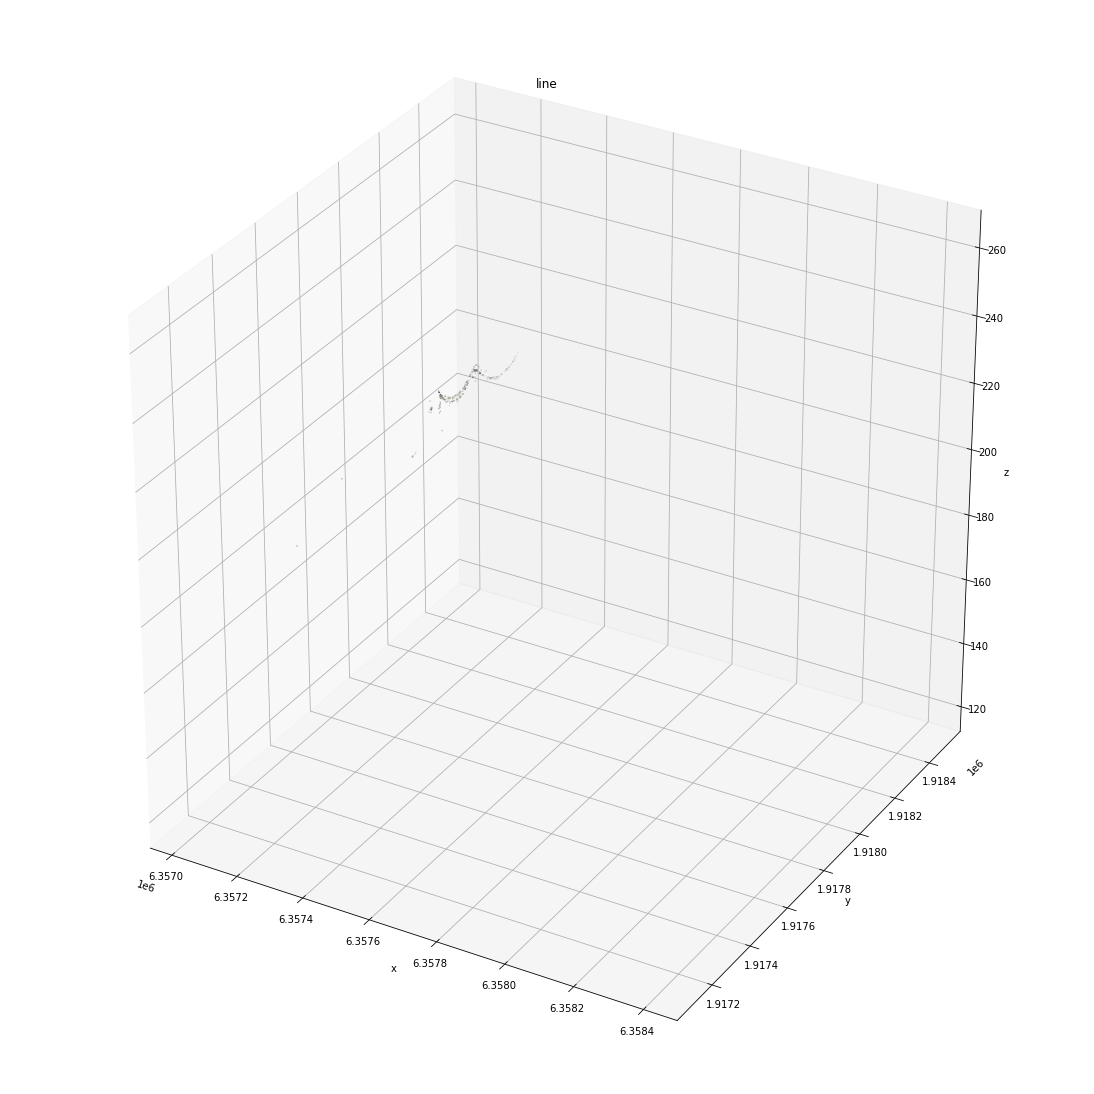

In [ ]:
idx = np.zeros(xyz.shape[0], dtype=bool)
c = np.array(list(lp_un.dic.values()))
c = c[pids]
idx[c] = True
lp_t3 = generateLPByIDS(idx)

kwargs = {'LP': lp_t3, 'POINTS':xyz}
pts_t3 = getPointsFromSource(**kwargs)
kwargs = {'LP': lp_t3, 'POINTS':rgb}
rgb_t3 = getPointsFromSource(**kwargs)
#
ax = show(pts_t3,rgb_t3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('line')
ax.set_xlim(xyz_min[0],xyz_max[0])
ax.set_ylim(xyz_min[1],xyz_max[1])
ax.set_zlim(xyz_min[2],xyz_max[2])
plt.show()

# all lines

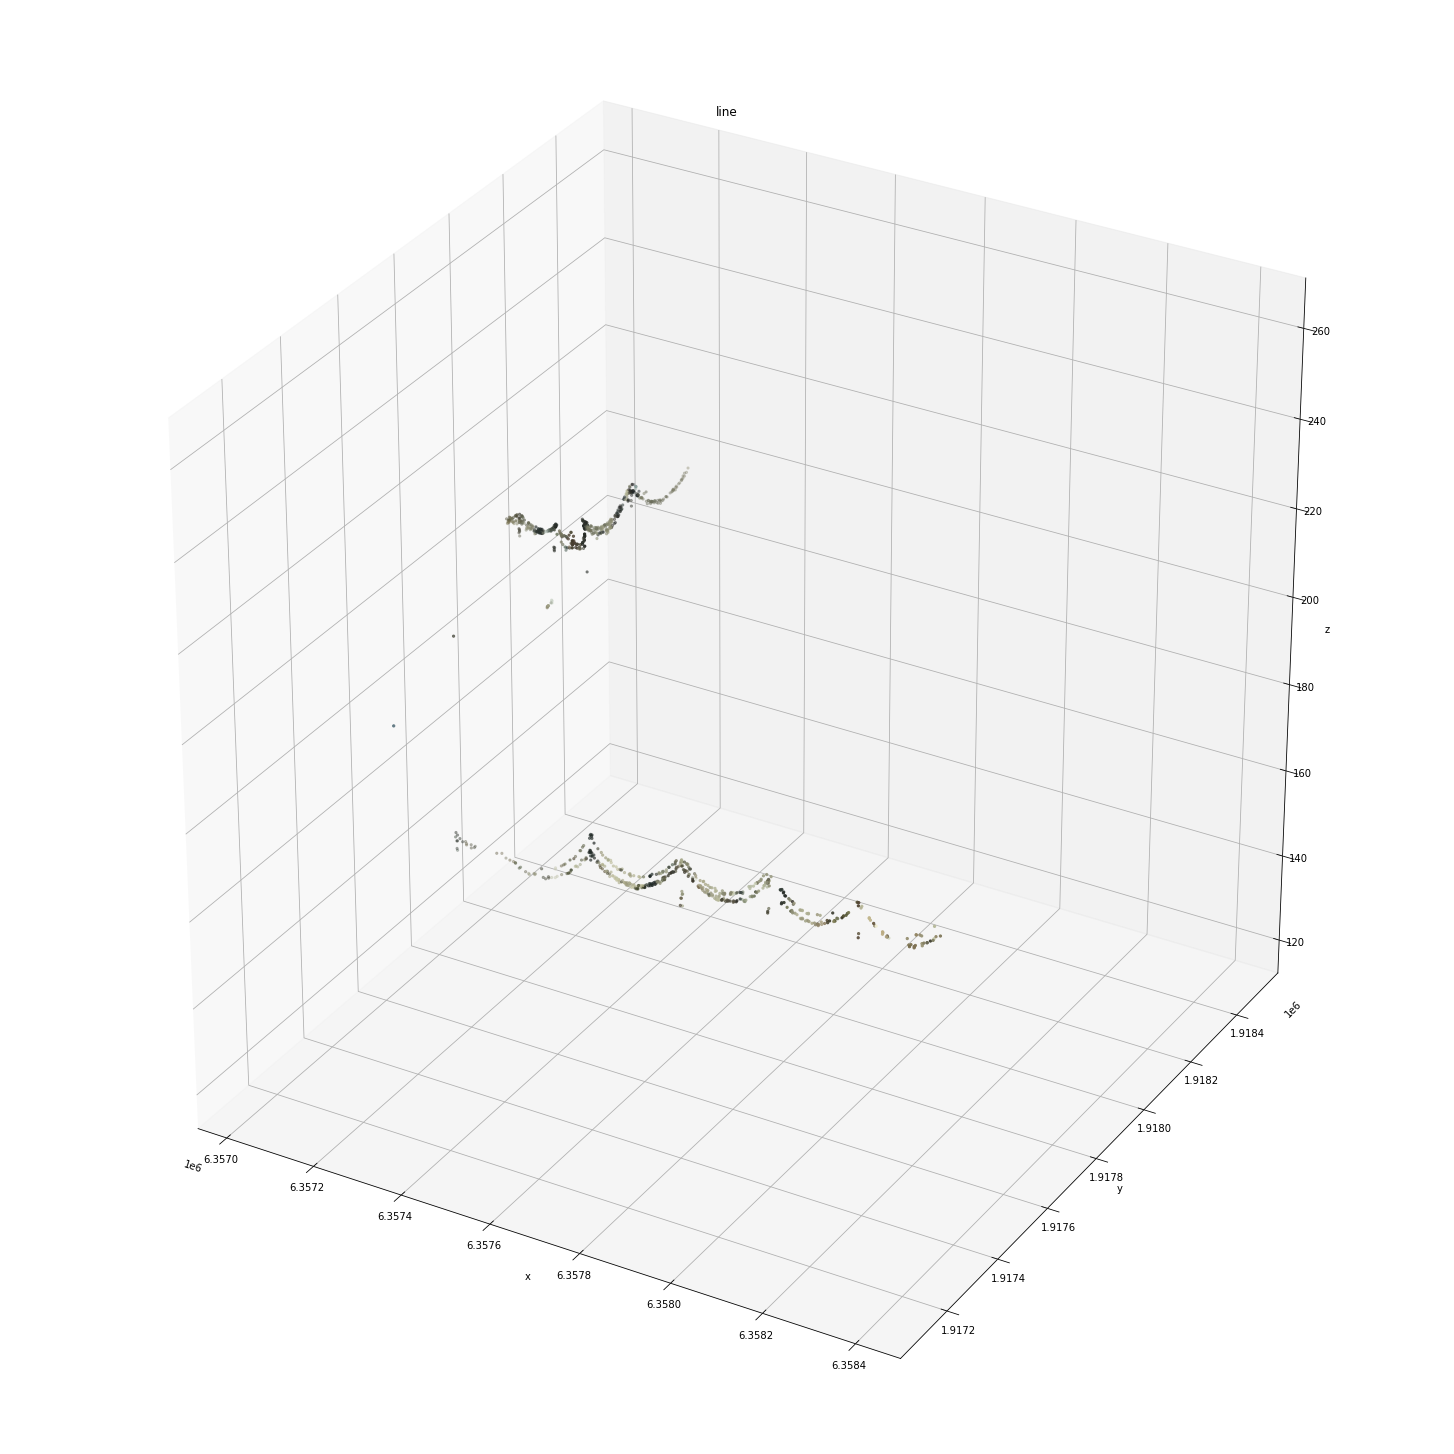

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,2,2],projection='3d')
ax.scatter(*(pts_t1.T), s=5, c=rgb_t1)
ax.scatter(*(pts_t2.T), s=5, c=rgb_t2)
ax.scatter(*(pts_t3.T), s=5, c=rgb_t3)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('line')
ax.set_xlim(xyz_min[0],xyz_max[0])
ax.set_ylim(xyz_min[1],xyz_max[1])
ax.set_zlim(xyz_min[2],xyz_max[2])
plt.show()

In [ ]:
a = pts_t2[:,2]
dz = calOutlierByIQR(a)
line2_max  = pts_t2.copy()
line2_max[:,2] = dz['upper_inner_fence']
line2_bottom = pts_t2.copy()
line2_bottom[:,2] = dz['lower_inner_fence']

In [ ]:
a = pts_t3[:,2]
dz = calOutlierByIQR(a)
line3_max  = pts_t3.copy()
line3_max[:,2] = dz['upper_inner_fence']
line3_bottom = pts_t3.copy()
line3_bottom[:,2] = dz['lower_inner_fence']

In [ ]:
zmin = dz['lower_inner_fence']
zmax = dz['upper_inner_fence']

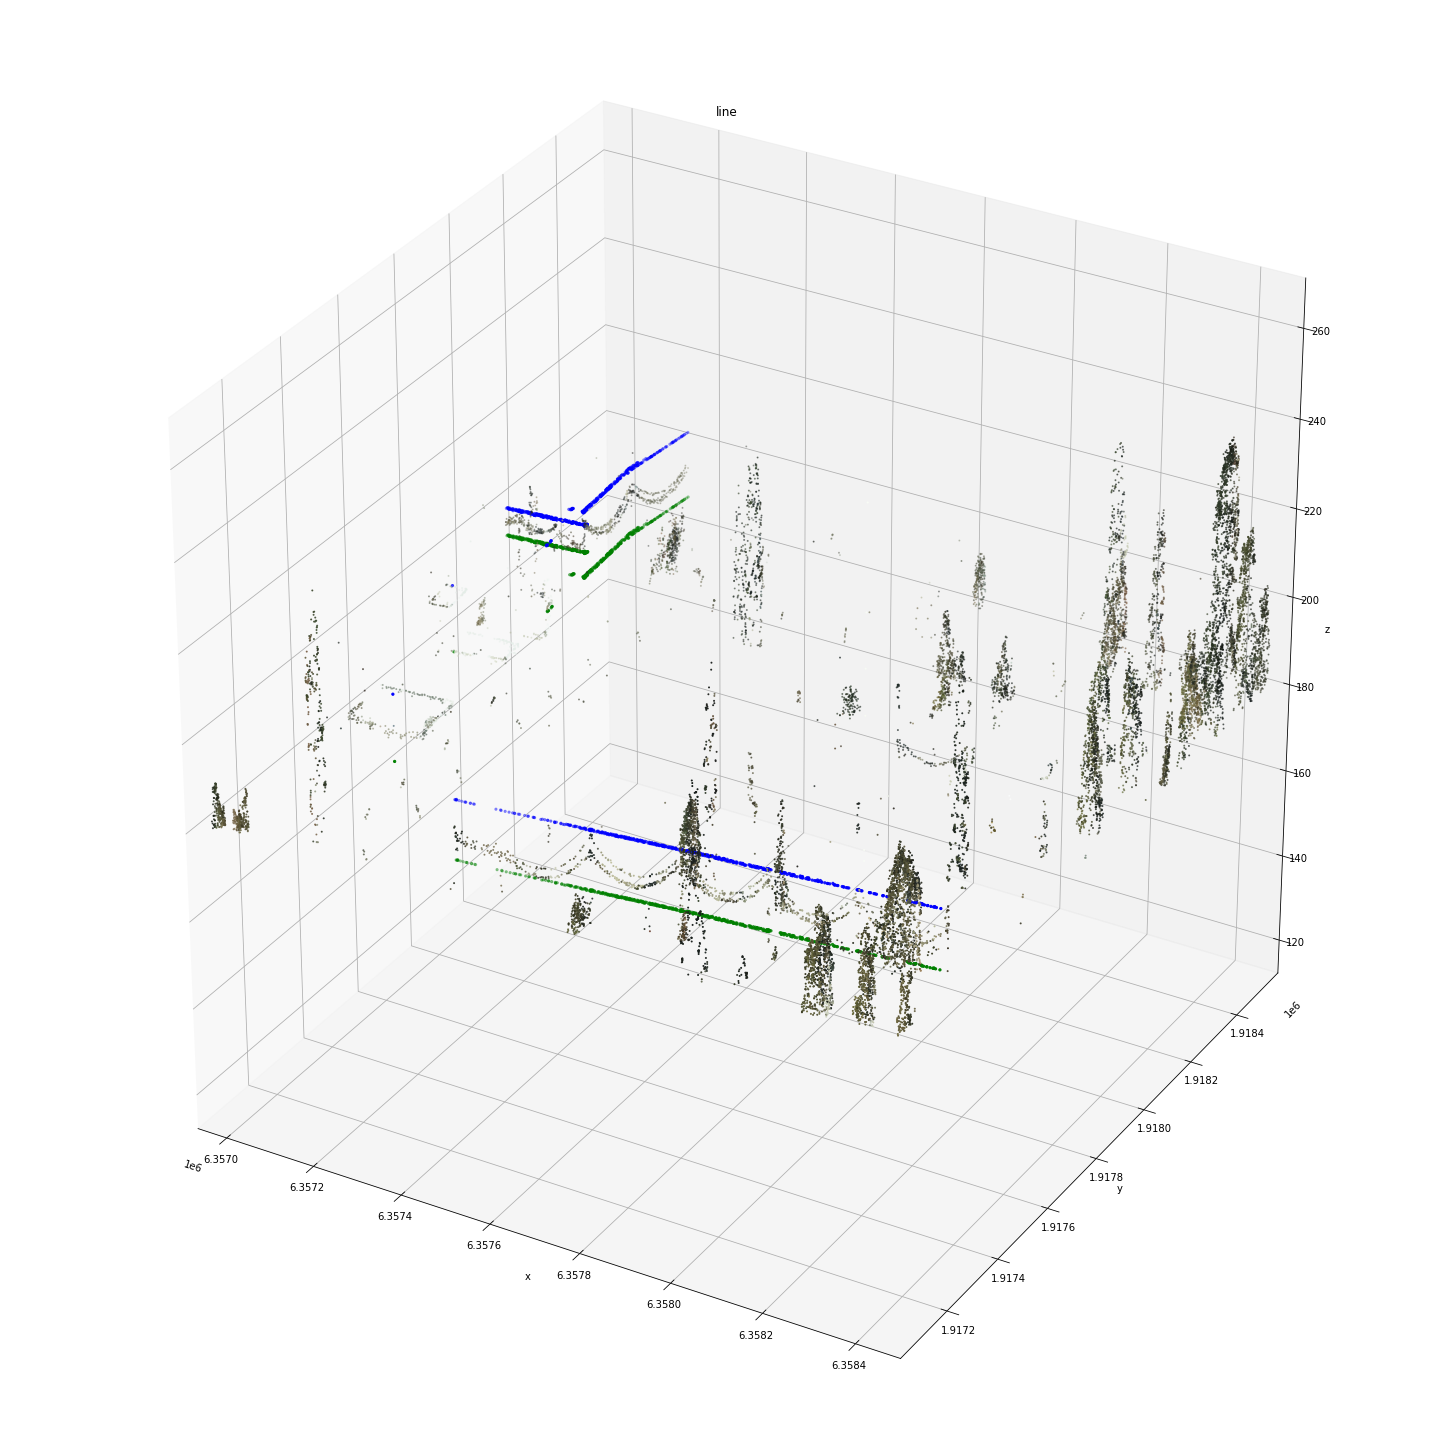

In [ ]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,2,2],projection='3d')
ax.scatter(*(pts_m180.T), s=1, c= rgb_m180)
#
#ax.scatter(*(line_mean.T), s=1, c='red')
ax.scatter(*(line_max.T), s=5, c='blue')
ax.scatter(*(line_bottom.T), s=5, c='green')

ax.scatter(*(line2_max.T), s=5, c='blue')
ax.scatter(*(line2_bottom.T), s=5, c='green')

ax.scatter(*(line3_max.T), s=5, c='blue')
ax.scatter(*(line3_bottom.T), s=5, c='green')
#
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('line')
ax.set_xlim(xyz_min[0],xyz_max[0])
ax.set_ylim(xyz_min[1],xyz_max[1])
ax.set_zlim(xyz_min[2],xyz_max[2])
plt.show()